# Lab 1: Convolutional Neural Networks

This notebook contains the key concepts and steps to implementing a Convolutional Neural Network.
Implementing the tasks below should give you an idea of how this method for image classification works.

## STEP 0: Get an idea about the dataset

### Nothing to be done here

**CIFAR** - Canadian Institute For Advanced Research.

CIFAR-10 and CIFAR-100 datasets were developed by the researchers at the CIFAR institute.

This dataset has 60.000 color (depth 3) images 32x32 (WxH) of objects from 10 classes:
- 0: airplane
- 1: automobile
- 2: bird
- 3: cat
- 4: deer
- 5: dog
- 6: frog
- 7: horse
- 8: ship
- 9: truck.

These are really small images and suitable for the purposes of this lab: we want to learn 
how to implement a convolutional neural network, without painfully waiting for the training to end.

The images are indeed very small compared to modern photographs. It can be challenging to see what exactly is represented in some of them. This low resolution is likely the cause of the limited performance that top-of-the-line algorithms are able to achieve on the dataset.

On this dataset it is relatively straightforward to achieve 80% classification accuracy.
Using deep CNNs a top performance above 90% accuracy is achieved.



In [1]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-10-04 22:44:29.114942: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-04 22:44:29.135950: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-04 22:44:29.136590: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-04 22:44:29.741671: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  0


2023-10-04 22:44:30.205703: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-04 22:44:30.217933: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Train shape: X=(50000, 32, 32, 3), y=(50000, 1)
Test shape: X=(10000, 32, 32, 3), y=(10000, 1)


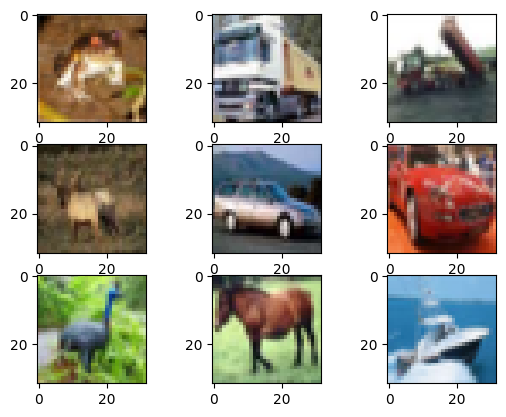

In [2]:
from keras.datasets import cifar10
from keras.utils import to_categorical
import tensorflow as tf

import matplotlib.pyplot as plt

# download cifar data and split into train and test sets
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# summarize the loaded dataset
# 50,000 training samples and 10,000 test samples (size: 32x32x3)
print('Train shape: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test shape: X=%s, y=%s' % (X_test.shape, y_test.shape))

# plot first 9 images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)

    # plot raw pixel data
    plt.imshow(X_train[i])

# show the figure
plt.show()

## STEP 1: Load the data
### 1.1. Load the dataset
### 1.2. Reshape the inputs

> Reshape the dataset inputs X_train and X_test to fit the model. Here 50000 is the number of samples, 32 is the width/height, 3-for the channels of color - Keras requires this 3rd dimension.

### 1.3. One-hot encode the target column
> E.g. if the input image contains a plane, the 3rd element of the target column is going to be 1 and the rest of the elements 0.




In [3]:
def load_data():
    # TODO 1.1. load the dataset
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()

    # TODO 1.2. reshape the inputs (train and test)
    X_train = tf.transpose(X_train, perm=(0, 1, 2, 3))
    X_test = tf.transpose(X_test, perm=(0, 1, 2, 3))

    # TODO 1.3. one-hot encode the target column (train and test)
    y_train = tf.one_hot(y_train.squeeze(1), depth=10)
    y_test = tf.one_hot(y_test.squeeze(1), depth=10)

    print("y_train[0] one hot: ", y_train[0])
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_data()


y_train[0] one hot:  tf.Tensor([0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(10,), dtype=float32)


## STEP 2: Prepare the data
### 2.1. Convert the pixels 
> From integers to floats.

### 2.2. Normalize the pixel values 
> From [0, 255] to [0.0, 1.0]. This is optional but in general using smaller values tends to give better results. Try also without this pre-processing and look at the loss.

In [4]:
def prepare_data(train, test):
    # TODO 2.1. convert int to float
    train = tf.cast(train, tf.float32)
    test = tf.cast(test, tf.float32)

    # TODO 2.2. normalize to range [0.0, 1.0]
    train_norm = train / 255.
    test_norm = test / 255.

    # return the normalized images
    return train_norm, test_norm

X_train, X_test = prepare_data(X_train, X_test)

## STEP 3: Build the model

### 3.1. Create the model:
> Sequential() is the easiest way to build a model in Keras. This allows you to build a model layer by layer. There is also Model() - class. Not in the scope of this lab.
         
         
### 3.2. Add layers.
> We can add the layers directly in the constructor (as a list) or later, using add().
  - **L1**: a **convolutional layer** with **32 nodes**. Kernel size is 3 => **3x3 filter** matrix. Note that on the first conv layer we need to specify the input shape. The best parameters for this layer: **padding='same'**, **activation='relu'**.
  - **L2**: In the second (also **conv**) layer we have **32 nodes** and the same parameters as above. 
  - **L3**: **Max Pooling** with **2x2 size** for the filter - can try without it and see what happens with the train time/loss.
  - **L4**: Add a **dropout** layer - commonly used to prevent overfitting. Drop **1/4** of the neurons.
  - **L5**: Add a **convolutional** layer with **64 neurons**, **kernel size 3**, **padding same** and **activation relu**.
  - **L6**: Add a **convolutional** layer with **64 neurons**, **kernel size 3** and **activation relu**.
  - **L7**: Add a **Max Pooling** layer with **filter size 2x2**.
  - **L8**: Add a **Dropout** layer, with **1/4** of the neurons dropped.
  - **L9**: Add a **Flatten** layer - the flatten layer serves as a connection b/w the conv and dense layers. Flatten = squeeze into 1D the activation maps and put them together. (Aka convert matrix to single array).
  - **L10**: Add a **Dense** layer with **512** nodes, **relu** activation.
  - **L11**: Add a **Dropout** layer, where **half** of the neurons are **dropped**.
  - **L12**: Add a **Dense** layer. In this case the Dense layer is used for the output layer: **10 nodes**, for each possible outcome (0 - 10). The activation is **softmax** - makes the outputs to sum up to 1 => interpret them as probabilities.  The model is going to make its prediction based on which option has the highest probability.


In [5]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

def build_model():
    # Specify the input shape
    inputs = layer = tf.keras.Input(shape = X_train.shape[1:])

    # TODO L1: add a CONV  layer with 32 nodes, kernel size is 3, padding same, activation relu
    layer = Conv2D(32, (3, 3), activation='relu', padding='same')(layer)

    # TODO L2: add a CONV layer with 32 nodes, kernel size is 3, activation relu
    layer = Conv2D(32, (3, 3), activation='relu')(layer)

    # TODO L3: add a Max Pooling layer, 2x2
    layer = MaxPooling2D((2, 2))(layer)

    # TODO L4: add a Dropout layer, drop 1/4 of the neurons
    layer = Dropout(rate=.25)(layer)

    # TODO L5: add a CONV layer with 64 neurons, kernel size is 3, padding same and the activation is relu
    layer = Conv2D(64, (3, 3), padding='same', activation='relu')(layer)

    # TODO L6: add a CONV layer with 64 nodes, kernel size is 3, activation relu
    layer = Conv2D(64, (3, 3), activation='relu')(layer)

    # TODO L7: add a Max Pooling layer with filter size 2x2
    layer = MaxPooling2D((2, 2))(layer)

    # TODO L8: add a Dropout layer; drop 1/4 of the neurons
    layer = Dropout(rate=.25)(layer)

    # TODO L9: add a Flatten layer
    layer = Flatten()(layer)

    # TODO L10: Add a Dense layer, 512 neurons and activation relu
    layer = Dense(512, 'relu')(layer)

    # TODO L11: Add a Dropout layer; drop 1/2 of the neurons
    layer = Dropout(.5)(layer)

    # TODO L12: Add a Dense layer, with 10 neurons and softmax as activation
    layer = Dense(10, activation='softmax')(layer)

    # Compose the model
    return tf.keras.Model(inputs=inputs, outputs=layer)

model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 64)        18496     
                                                             

## STEP 4: Compile the model
> Here we are going to need and optimizer, a loss function and a metric.
  - **Optimizer** 
     - controls the learning rate. Here: **Adam** - a good optimizer for many cases.
       Adam adjusts the learning rate throughout training.
       Learning rate = how fast the optimal weights for the model are computed.
       The LR value involves a trade-off b/w speed (larger lr) and accuracy(smaller lr).
     - Other optimizers: https://keras.io/optimizers/  
  - **Loss**
     - **categorical_crossentropy** - a common choice for classification ( > 2 classes). The lower the score, the better.
     - Other losses: https://keras.io/losses/ 
  - **Metric**
     - **accuracy** - not the best choice but it is ok to make things easier.

In [6]:
# TODO 4. compile() the model using the adam optimizer, categorical crossentropy as loss and accuracy as metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## STEP 5: Train the model
> Use the **fit()** function with the parameters:
  - training data: **train_X** (images)
  - target data: **train_y** (labels)
  - **validation data**: **X_test**, **y_test** (periodically used during training to measure the performance of the model against data it has not seen before.)
  - number of **epochs**: the number of times the model is cycling through the data. Not to large as the model only improves up to a certain point. Set to **100** in this case.
  - **shuffle** the data for batches.
  - a **batch size** of **64** is ok. 

In [7]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=64,
    epochs=100,
    shuffle=True,
    steps_per_epoch=64,
    validation_data=(X_test, y_test)
)

Epoch 1/100


64/64 [==============================] - 2s 19ms/step - loss: 2.2065 - accuracy: 0.1545 - val_loss: 1.9395 - val_accuracy: 0.2890
Epoch 2/100
64/64 [==============================] - 1s 18ms/step - loss: 1.8683 - accuracy: 0.3137 - val_loss: 1.7228 - val_accuracy: 0.3649
Epoch 3/100
64/64 [==============================] - 1s 18ms/step - loss: 1.7019 - accuracy: 0.3735 - val_loss: 1.6336 - val_accuracy: 0.3859
Epoch 4/100
64/64 [==============================] - 1s 18ms/step - loss: 1.6358 - accuracy: 0.4087 - val_loss: 1.5145 - val_accuracy: 0.4456
Epoch 5/100
64/64 [==============================] - 1s 17ms/step - loss: 1.5826 - accuracy: 0.4087 - val_loss: 1.4669 - val_accuracy: 0.4542
Epoch 6/100
64/64 [==============================] - 1s 18ms/step - loss: 1.5137 - accuracy: 0.4492 - val_loss: 1.4245 - val_accuracy: 0.4709
Epoch 7/100
64/64 [==============================] - 1s 18ms/step - loss: 1.4592 - accuracy: 0.4746 - val_loss: 1.3544 - val_accuracy: 0.5155
Epoch 8/100
64/64 

In [8]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## STEP 6: Save the model

From this model we are interested in the weights. Thus, in order to use the model later, we need to save the weights learned at training time.

In [9]:
model.save_weights('cifar_cnn.h5')

## STEP 7: Make predictions
> Use the **predict()** function to see the actual predictions that our model has made for the test data.The predict() function gives an array with 10 numbers - the probaility that th input is 0-9. The array index with the highest value is the prediction made by the model.

> Additionally: re-load the trained model. Essentially what we have to do here is to rebuild the model and load in the saved weights.

In [10]:
import numpy as np

def load_test_model():
    # TODO 7.1. (re)build the model
    test_model = build_model()

    # TODO 7.2. load the model's saved weights.
    test_model.load_weights('cifar_cnn.h5')

    # TODO 7.3. Predict the class of the first 10 images in the test set
    predictions = test_model.predict(x=X_test, batch_size=64)

    # 7.4. Print the predictions done by the model ([7, 2, 1, 0, 4])
    print("Predictions: \n", np.argmax(predictions, axis=1))

    # 7.5. Check our predictions against the ground truths ([7, 2, 1, 0, 4])
    print("Ground truth: \n", y_test[:10])

load_test_model()

 59/157 [==========>...................] - ETA: 0s

157/157 [==============================] - 0s 3ms/step
Predictions: 
 [3 8 8 ... 5 0 7]
Ground truth: 
 tf.Tensor(
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(10, 10), dtype=float32)


## STEP 8: Learning Curves

Plot the learning curves to get an idea about how the model learns, overfitting, etc.

> 76.520


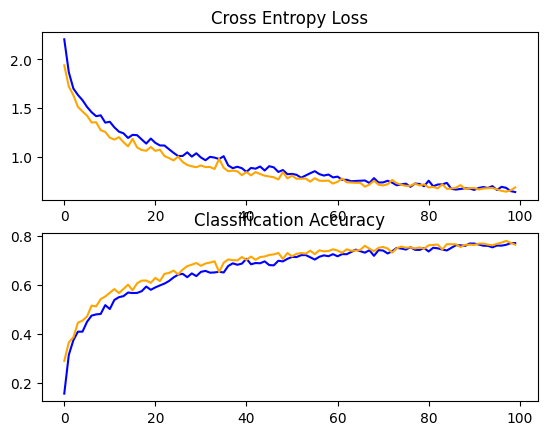

In [11]:
import sys

# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')

    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')

    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    plt.savefig(filename + '_plot.png')


plt.show()

# evaluate model
_, acc = model.evaluate(X_test, y_test, verbose=0)

print('> %.3f' % (acc * 100.0))

# learning curves
summarize_diagnostics(history)

## BONUS

With the knowledge achieved through this lab, build a simplified CNN which is able to classify the digits in the MNIST dataset. The network does not need to have more than 2 convolutional layers in order for the performance to be satisfactory in terms of accuracy.

Note that the MNIST dataset is lighter than CIFAR as the images are grayscale (only one color channel).

11490434/11490434 [==============================] - 1s 0us/step
image shape:  (28, 28)


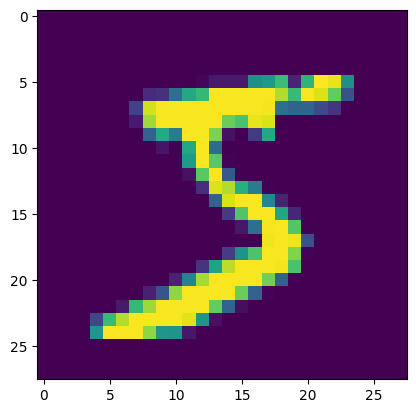

In [14]:
import os

from keras.datasets import mnist
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

import matplotlib.pyplot as plt

# TODO B1. Download mnist data and split into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Plot the first image in the dataset
plt.imshow(X_train[0])

# Check the image shape
print("image shape: ", X_train[0].shape)

In [15]:
######################
# B2. Prepare the data
######################
# TODO B2.1. Normalize the pixel values from [0, 255] to [-0.5, 0.5].
X_train = (X_train - 127.5) / 255.
X_test = ()

# TODO B2.2. Reshape the dataset inputs X_train and X_test to fit the model 
# train: (60000, 28, 28, 1), test: (10000, 28, 28, 1)


# TODO B2.3. One-hot encode the target column
print("y_train[0] one hot: ", y_train[0])

y_train[0] one hot:  5


In [ ]:
#####################
# B3. Build the model
#####################

# TODO B3.1. Create model

# TODO B3.2. Add conv layer - 64 nodes, 3x3, relu

# TODO B3.3. Add conv layer - 32 nodes, 3x3, relu

# TODO B3.4. Add max pooling layer - 2x2 pool size

# TODO B3.5. Add a dropout layer - 0.5

# TODO B3.6. Aadd flatten layer

# TODO B3.7. Add dense layer - 10 nodes, softmax

In [ ]:
#######################
# B4. Compile the model
#######################

# TODO B4. Optimizer: adam, Loss: categorical_crossentropy, Metric: accuracy.

In [ ]:
#####################
# B5. Train the model
#####################

# TODO B5. Use the fit() function with the parameters:
#   - training data: train_X (images)
#   - target data: train_y (labels)
#   - validation data: X_test, y_test 
#   - number of epochs: 3
history = # TODO

In [ ]:
######################
# B6. Make predictions
######################

# Predict
print("Predictions for the first 4 test samples: \n", model.predict(X_test[:4]))

# Compare with the actual results
print("Actual values in the test set: \n", y_test[:4])

In [ ]:
#####################
# B7. Using the model
#####################

# TODO B7. Save model


In [13]:
##############################
# B8. Plot the learning curves
##############################

# TODO B8.1. Evaluate model
_, acc = # TODO

print('> %.3f' % (acc * 100.0))

# TODO B8.2. Plot the learning curves


SyntaxError: invalid syntax (3767954184.py, line 68)